# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)

## Preliminaries

In [12]:
##Hyperparameters

Channel = [24,72,216,648]
Kernel_size = [7, 5, 3, 2]
Stride = [1, 1, 1, 1]
Padding = [1, 1, 1, 1]
Dense_features=[2048, 512, 128, 10]
Learning_rate=0.001
dropoutc = 0.01
dropoutl = 0.3
Epochs = 4
Batch_size = 16
beta1 = 0.9
beta2= 0.999
weight_decay=1e-5

Input_width = (32-Kernel_size[0] + 2*Padding[0])/Stride[0] + 1
print(Input_width)
Input_width = (Input_width-2)/2 + 1
print(Input_width)
Input_width = (Input_width - Kernel_size[1] + 2*Padding[1])/Stride[1] + 1
print(Input_width)
Input_width = (Input_width-2)/2 + 1
print(Input_width)
Input_width = (Input_width - Kernel_size[2] + 2*Padding[2])/Stride[2] + 1
print(Input_width)
Input_width = (Input_width-2)/2 + 1
Input_width = (Input_width - Kernel_size[3] + 2*Padding[3])/Stride[3] + 1
print(Input_width)
Input_width = (Input_width-2)/2 + 1
Input_width = int(Input_width)
print(Input_width)


28.0
14.0
12.0
6.0
6.0
4.0
2


## Loading and normalizing CIFAR10



In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.init as init
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        normalize=normalize
    )


def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [3]:
# The output of torchvision datasets are PIL images in the range [0, 1].
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

train_data_iter = iter(train_loader)
test_data_iter = iter(test_loader)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print("# Training data")
print("Number of points:", len(train_set))
x, y = next(iter(test_loader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(train_set.targets)))


print("\n# Test data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(test_set.targets)))

# Training data
Number of points: 50000
Batch dimension [B x C x H x W]: torch.Size([64, 3, 32, 32])
Number of distinct labels: 10

# Test data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([64, 3, 32, 32])
Number of distinct labels: 10


Let us show some of the training images, for fun.



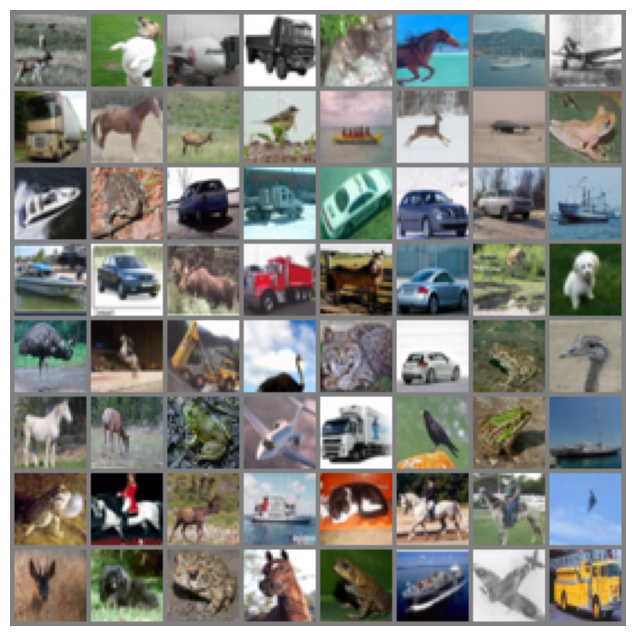

In [9]:
# Get random training images and show them.
data_iter = iter(train_loader)
images, labels = next(data_iter)
show_image(torchvision.utils.make_grid(images))

## Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network.
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [15]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes


        self.conv_1 = nn.Conv2d(in_channels=3,
                             out_channels=Channel[0],
                             kernel_size=Kernel_size[0],
                             stride=Stride[0], padding=Padding[0])
        self.bn1 = torch.nn.BatchNorm2d(Channel[0])

        self.Maxpool = nn.MaxPool2d(2, 2)

        self.conv_2 = nn.Conv2d(in_channels=Channel[0],
                             out_channels=Channel[1],
                             kernel_size=Kernel_size[1],
                             stride=Stride[1], padding=Padding[1])
        self.bn2 = torch.nn.BatchNorm2d(Channel[1])


        self.conv_3 = nn.Conv2d(Channel[1],
                             out_channels=Channel[2],
                             kernel_size=Kernel_size[2],
                             stride=Stride[1], padding=Padding[2])
        self.bn3 = torch.nn.BatchNorm2d(Channel[2])
        self.conv_4 = nn.Conv2d(in_channels=Channel[2],
                             out_channels=Channel[3],
                             kernel_size=Kernel_size[3],
                             stride=Stride[3], padding=Padding[3])
        self.bn4 = torch.nn.BatchNorm2d(Channel[3])


        self.l1_in_features = Channel[3] * Input_width * Input_width

        self.dropoutc = nn.Dropout2d(p=dropoutc)
        self.dropoutl = nn.Dropout2d(p=dropoutl)

        self.l_1 = nn.Linear(in_features=self.l1_in_features,
                          out_features=Dense_features[0],
                          bias=True)
        self.l_2 = nn.Linear(in_features=Dense_features[0],
                            out_features=Dense_features[1],
                            bias=True)
        self.l_3 = nn.Linear(in_features=Dense_features[1],
                            out_features=Dense_features[2],
                            bias=False)
        self.l_4 = nn.Linear(in_features=Dense_features[2],
                            out_features=Dense_features[3],
                            bias=False)

        self.bnL1 = torch.nn.BatchNorm1d(Dense_features[0])
        self.bnL2 = torch.nn.BatchNorm1d(Dense_features[1])
        self.bnL3 = torch.nn.BatchNorm1d(Dense_features[2])
        self.bnL4 = torch.nn.BatchNorm1d(Dense_features[3])


    def forward(self, x):
        # Your code here!
        x = F.relu(self.conv_1(x))
        x = self.bn1(x)
        x = self.Maxpool(x)
        x = F.relu(self.conv_2(x))
        x = self.bn2(x)
        x = self.Maxpool(x)
        x = F.relu(self.conv_3(x))
        x = self.bn3(x)
        x = self.Maxpool(x)
        x = F.relu(self.conv_4(x))
        x = self.bn4(x)
        x = self.Maxpool(x)
        x = self.dropoutc(x)
        x = x.view(-1, self.l1_in_features)
        x = F.relu(self.l_1(x))
        x = self.bnL1(x)
        x = F.relu(self.l_2(x))
        x = self.bnL2(x)
        x = F.relu(self.l_3(x))
        x = self.bnL3(x)
        x = F.relu(self.l_4(x))
        x = self.bnL4(x)
        x = self.dropoutl(x)
        return x



net = Net(10).cuda()
device = torch.device('cpu')  # use cuda or cpu
net.to(device)
print(net)

Net(
  (conv_1): Conv2d(3, 24, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(24, 72, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(72, 216, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(216, 648, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(648, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropoutc): Dropout2d(p=0.01, inplace=False)
  (dropoutl): Dropout2d(p=0.3, inplace=False)
  (l_1): Linear(in_features=2592, out_features=2048, bias=True)
  (l_2): Linear(in_features=2048, out_features=512, bias=True)
  (l_3): Linear

## Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer.
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [9]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=Learning_rate,betas=(beta1, beta2),  weight_decay = weight_decay)

## Train the network

**Assignment 3:** Finish the training loop below.
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch  1 : Train Loss 152.075424 , Train acc 0.101700, Valid acc 0.104267


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch  2 : Train Loss 152.540934 , Train acc 0.102780, Valid acc 0.104167


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch  3 : Train Loss 152.187857 , Train acc 0.103980, Valid acc 0.104267


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch  4 : Train Loss 152.344176 , Train acc 0.102360, Valid acc 0.102564
Finished Training


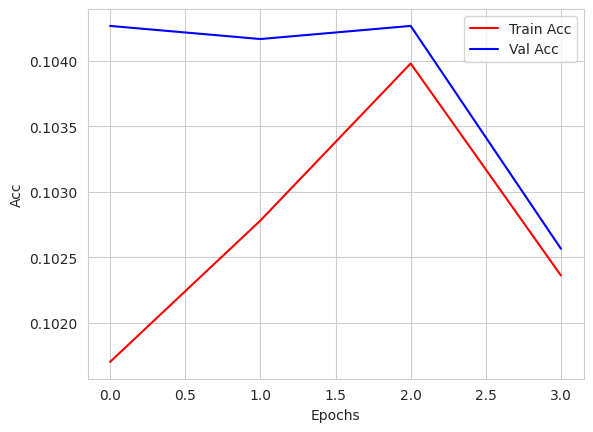

In [16]:
num_epoch = Epochs # Your code here!
from sklearn.metrics import accuracy_score

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []


for epoch in range(num_epoch):  # loop over the dataset multiple times


    ### Evaluate training
    running_loss = 0.0

    net.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        # Your code here!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Your code here!
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()

    losses.append(running_loss / Batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i, data in enumerate(train_loader, 0):
                # get the inputs
        inputs, label = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(label.cuda())

        # zero the parameter gradients
        # Your code here!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Your code here!
        output = net(inputs)
        preds = torch.max(output, 1)[1]
        preds = preds.cpu()
        train_targs += list(label)
        train_preds += list(preds.data.numpy())



    ### Evaluate validation
    val_preds, val_targs = [], []
    for i, data in enumerate(test_loader, 0):
                # get the inputs
        inputs, label = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        # Your code here!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Your code here!
        output = net(inputs)
        preds = torch.max(output, 1)[1]
        preds = preds.cpu()
        val_preds += list(preds.data.numpy())
        val_targs += list(label)


    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)

    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)

    if epoch % 1 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')

print('Finished Training')

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

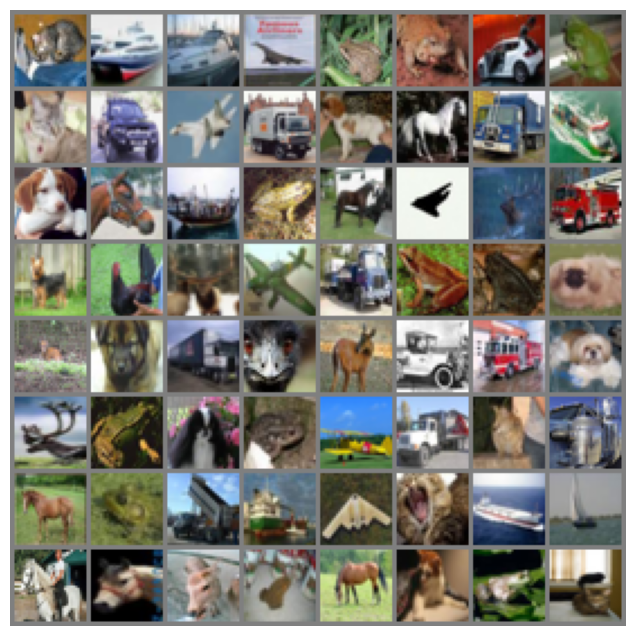

    TRUE        PREDICTED
-----------------------------
     cat          frog     
    ship       automobile  
    ship        airplane   
  airplane        bird     
    frog          ship     
    frog          truck    
 automobile    automobile  
    frog       automobile  
     cat          bird     
 automobile       horse    
  airplane        truck    
    truck         truck    
     dog       automobile  
    horse         bird     
    truck         bird     
    ship          truck    
     dog          ship     
    horse         truck    
    ship          horse    
    frog          horse    
    horse          cat     
  airplane     automobile  
    deer          deer     
    truck         truck    
     dog           cat     
    bird          deer     
    deer          ship     
  airplane        bird     
    truck         frog     
    frog           cat     
    frog          horse    
     dog          frog     
    deer          frog     
     dog          de

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [22]:
inputs, targets = iter(test_loader).__next__()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = net(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")

We now evaluate the network as above, but on the entire test set.



In [18]:
import numpy as np
import torch

# Assuming net, test_loader, criterion, and other variables are defined previously

# Move the model to GPU if it's not already there
net.to(device)

# Initialize the confusion matrix on the same device as the model (CPU or GPU)
confusion_matrix = torch.zeros(10, 10, device=device)

with torch.no_grad():
    net.eval()
    test_accuracies = []

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = net(inputs)
        loss = criterion(output, targets)
        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))

        # Compute the confusion matrix on the same device as the model
        for t, p in zip(targets.view(-1), predictions.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    test_accuracy = np.sum(test_accuracies) / len(test_set)

    net.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/funct

In [19]:
# Imprime la matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix)


Confusion Matrix:
tensor([[131.,  92., 115., 116., 117.,  75.,  78.,  47.,  92., 135.],
        [ 63., 116.,  95., 110., 135.,  48., 111., 112., 126.,  83.],
        [ 81., 112., 106., 114., 100., 155.,  59.,  96.,  75., 101.],
        [ 88., 108., 113., 114.,  88., 142.,  72.,  89.,  90.,  93.],
        [ 65., 102., 133., 100.,  66., 195.,  66.,  77., 104.,  92.],
        [ 83.,  95., 118.,  77.,  99., 107.,  80., 148.,  84., 106.],
        [ 59., 126., 122.,  97.,  81., 134.,  72., 107., 107.,  95.],
        [108.,  92., 104., 110., 100., 112.,  61., 120., 104.,  86.],
        [122.,  88., 116., 131.,  66.,  95.,  85.,  50., 101., 143.],
        [103.,  81., 113., 118.,  99.,  66., 100., 103., 126.,  91.]])


In [21]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.102


Here we look a bit more in depth into the performance of the classifier, using the confusion matrix. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly how they are misclassified by looking at the rest of the row.

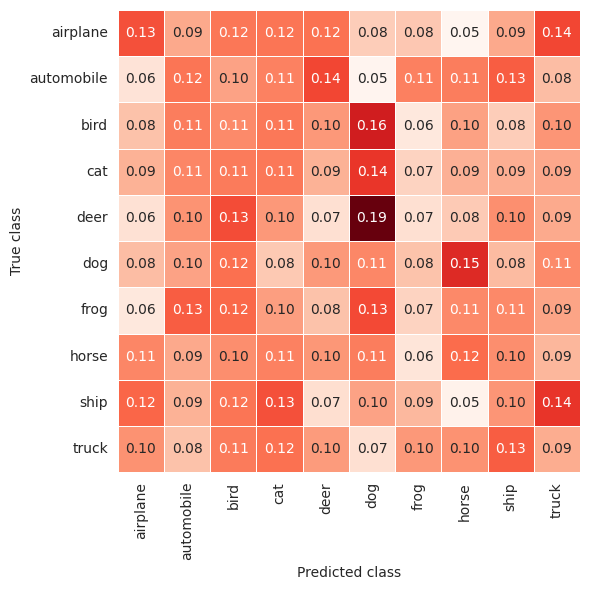

In [22]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

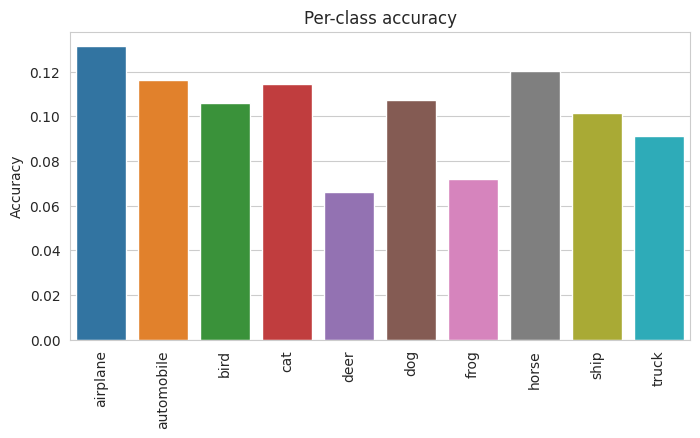

In [23]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:**
1. Go back and improve performance of the network.
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

Interestingly, dropout, while seemingly decreasing performance, reduced the gap between validation and training accuracy. This suggests that it helps the model converge to more optimal weights, even though it may slightly lower accuracy.

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**

- Dropout apparently decrease the performance of the model, however, it short the distance between the validation and train accuracy. So I think that at the limit it helps on reaching more optimal weights.


# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU?
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Setting up GPU in Colab

In Colab, you will get 12 hours of execution time but the session will be disconnected if you are idle for more than 60 minutes. It means that for every 12 hours Disk, RAM, CPU Cache and the Data that is on our allocated virtual machine will get erased.

To enable GPU hardware accelerator, just go to **Runtime -> Change runtime type -> Hardware accelerator -> GPU**

# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)


Verify that σ′(z)=σ(z)(1−σ(z)).

**Answer:**

The sigmoid function is:

$\sigma(z)=\frac{1}{1+e^{−z}}$.

Then by substuting $\sigma$ in the statement of the question we can obtain that:

 $\sigma '= \frac{1}{1+e^{−z}}·(1-\frac{1}{1+e^{−z}})=\frac{e^{−z}}{(1+e^{−z})^2}$

On the other hand, by transforming the fraction to potency we get:

 $\sigma = (1+e^{−z})^{−1}$.

Doing the derivative of the equation above, we obtain:

$\sigma' = (-1)(-e^{−z})(1+e^{−z})^{−2}=\frac{e^{−z}}{(1+e^{−z})^2}$.

Finally, we can verify that in both ways, we reach the same function.

